# SpaCy Named Entity Recognition Implementation

## (Professor/TA: Request access to our Shared Google Drive housing the data/models by emailing: akash.jagannathan@sjsu.edu, karanbir.bains@sjsu.edu, and/or sudanshushekhar@sjsu.edu) 

###Mount drive with data 

In [1]:
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/Shared\ drives/256Group10/ASKus


/content/drive/Shared drives/256Group10/ASKus


## Data Exploration and Preprocessing

### Load train.csv containing matrix with paper id's corresponding to dataset label

In [4]:
import pandas as pd
import os

import fileinput
import time

import ast

import re

import spacy as sp
from spacy.util import minibatch, compounding
from pathlib import Path

import random

import json

In [5]:


train = pd.read_csv('./data/train.csv')
train

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
...,...,...,...,...,...
19656,b3498176-8832-4033-aea6-b5ea85ea04c4,RSNA International Trends: A Global Perspectiv...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID Open Radiology Database,rsna international covid open radiology database
19657,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...
19658,ab59bcdd-7b7c-4107-93f5-0ccaf749236c,Quantitative Structure–Activity Relationship M...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...
19659,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...


### **Data Exploration**

In [ ]:
# start with a single file
trainJSON = pd.read_json('./data/train/ef0a0fb9-5b60-4e79-90d0-6c8d71e6aa48.json')
trainJSON

,section_title,text
0,Abstract,A number of recent studies have not replicated...
1,,To replicate an experiment in human biology an...


In [ ]:
# now get the pathnames of all of the JSON files into an array
path_to_json = './data/train/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]


In [ ]:
# create the arrays to be filled
## will be filled with all of the pathnames names of each file
filenames = []
## will contain all of the text per file
texts = []
## will contain the title or id of each of the files
titles = []
## will contain the number of sections per document
sections = []

# for every file in the array...
for file in json_files:
  # create the path to the file
  filepath = path_to_json + file
  # read the file into a pandas dataframe
  file_df = pd.read_json(filepath)
  # extract and concate all of the text into a single varaible
  text = file_df["text"].str.cat()
  # extract the title or id from the path
  title = file.split(".json")[0]
  # get the number of sections in the dataframe
  section = len(file_df)
  
  # append to data to its respective array
  sections.append(section)
  titles.append(title)
  filenames.append(file)
  texts.append(text)
  

# create a new data frame and fill it with data from the arrays
dtm_df = pd.DataFrame()
dtm_df.insert(0, "id", titles)
dtm_df.insert(1, "sections", sections)
dtm_df.insert(2, "text", texts)
  
# show the dataframe
dtm_df



,id,sections,text
0,ef0a0fb9-5b60-4e79-90d0-6c8d71e6aa48,2,A number of recent studies have not replicated...
1,ef1770e2-527a-4549-b345-ee002246af1f,36,Industrial policies that subsidize (often larg...
2,ef19c53d-899a-41ba-bb2a-6b03c9c97497,11,Obsessive-compulsive disorder (OCD) is a heter...
3,ef1a2ad5-73ea-42a6-839b-1092efa5e8ad,9,. Map Sprague's Pipits breed from north-centra...
4,ef228135-27af-4278-a225-57acd2ac0a82,7,most common observed substitutions in SARS-CoV...
...,...,...,...
14311,04e8222c-ff33-4881-9b80-7121063cde0c,9,Recent public health research documents geogra...
14312,04efcc82-9f89-4b40-a506-3a7cb34b5242,22,R epresentation by race and ethnicity is one o...
14313,04f0863b-54fa-4ae5-ad0e-a9b4d42e2a29,9,[1] Numerical model experiments are conducted ...
14314,04fd49ad-466e-4d07-8848-2158e4994515,10,Strong decadal variations in the oceanic uptak...


In [ ]:
# create the arrays to be filled
sentances = []
words = []

# for every row in the data frame
for field, row in dtm_df.items():
  # only work with the text column for each row
  if(field == 'text'):
    # for each row within the text column
    for textbook in range(0, 14316):
      # create an array of sentances
      arrayOfSentances = row.get(textbook).split(".") 
      # add the number of sentances into respective array
      sentances.append(len(arrayOfSentances))
      # create word count variable
      word = 0
      # for each sentance in the text
      for sentance in arrayOfSentances:
        # get the number of words in the sentance
        result = len(sentance.split())
        # add to the running total of wordcount
        word = word + result
      # add the number of words into respective array
      words.append(word)

# Print data 
# print("The number of sentances per article are: ")
# print(sentances)
# print("The number of words per article are: ")
# print(words)

In [ ]:
# get the average words, sentances, and sections per artcle
def AverageData(arr):
  return sum(arr)/len(arr)
averageWords = AverageData(words)
averageSenences = AverageData(sentances)
averageSections = AverageData(sections)

print("The Average Words per article are: ", averageWords)
print("The Average Sentences per article are: ", averageSenences)
print("The Average Sections per article are: ", averageSections)


The Average Words per article are:  7144.80546241967
The Average Sentences per article are:  577.8894244202291
The Average Sections per article are:  18.071668063704944


## SpaCy

In [ ]:
##script used to take json text files and train.csv and convert them to SpaCy friendly format (takes approx. 80 minutes to complete)

##create array to store tuples of publication text and entity (dataset name) locations (this is how SpaCy wants it)
# SPACY_TRAIN = []

##counter used to track progress
# count = 0

##loop through train.csv rows
# for index, row in train.iterrows():
#   print(count)
#   this_pub = ""

##load json file corresponding to publication id in the train.csv row, store known dataset label
#   this_pub_id = './data/train/' + row['Id'] + '.json'
#   this_data_lab = row['dataset_label']
#   this_pub_json = json.load(open(this_pub_id))

##append all text from the publication in to one (super-long!) string
#   for section in this_pub_json:
#     this_pub += section['text']

##Find locations of dataset in publications and store in an entity dictionary
#   this_ent_dict = {"entities": []}
#   for m in re.finditer(this_data_lab, this_pub):
#     this_ent_dict['entities'].append((m.start(), m.end()+1, LABEL))

## append the tuple of the entire publication text and the entity locations in the text
#   SPACY_TRAIN.append((this_pub, this_ent_dict))
#   count+=1

# SPACY_TRAIN

In [ ]:
#write SpaCy friendly training data into a text file

# file = open("./data/spacy/spacy_train.txt", "w")
# SPACY_TRAIN_File = repr(SPACY_TRAIN)
# file.write(SPACY_TRAIN_File)
# file.close()

In [6]:
#script to read in SpaCy friendly data from text file (script modified from one here: https://www.geeksforgeeks.org/how-to-read-large-text-files-in-python/)
  
#time at the start of program is noted
# start = time.time()
# spacy_train = ""
# #keeps a track of number of lines in the file
# count = 0
# for lines in fileinput.input(["./data/spacy/spacy_train.txt"]):
#     spacy_train = lines
#     count = count + 1
      
# #time at the end of program execution is noted
# end = time.time()
  
# #total time taken to print the file
# print("Execution time in seconds: ",(end - start))
# print("No. of lines printed: ",count)

# #number of chars in file (exceeds one billion)
# print("Number of characters in the data file (too many): ", len(spacy_train))

Execution time in seconds:  18.54279899597168
No. of lines printed:  1
Number of characters in the data file (too many):  1093591763


In [ ]:
#SpaCy friendly training data was read in from .txt file as a string - use following to convert back to list of tuples
#Source code: https://stackoverflow.com/questions/1894269/how-to-convert-string-representation-of-list-to-a-list

# DATA = ast.literal_eval(spacy_train)

# print("number of (paper, dataset_location) tuples in the data: ", len(DATA))

In [ ]:
#split data into 70% training and 30% test
#Train only on the 70% and keep the rest for evaluation purposes
#As model training and internal evaluation was done over multiple sessions, this was run once and the separate
# train and test data were saved to our shared Google Drive to maintain the integrity of our evaluation results,
# hence it is commented out here 

# #randomly shuffle the tuples
# random.shuffle(DATA)

# train_mark = (len(DATA)*7//10)
# TRAIN_FULL = DATA[:train_mark]
# TEST_FULL = DATA[train_mark:]

In [ ]:
# write train/test split into a text file, as model will be trained on this split

#As model training and internal evaluation was done over multiple sessions, this was run once and the separate
# train and test data were saved to our shared Google Drive to maintain the integrity of our evaluation results,
# hence it is commented out here 

# file = open("./data/spacy/TRAIN_FULL.txt", "w")
# TRAIN_FULL_SET = repr(TRAIN_FULL)
# file.write(TRAIN_FULL_SET)
# file.close()

# file = open("./data/spacy/TEST_FULL.txt", "w")
# TEST_FULL_SET = repr(TEST_FULL)
# file.write(TEST_FULL_SET)
# file.close()

In [7]:
#Load "train" set (70% training data held aside above)
#Note: these are not compressed into sentences, it is full texts.  The evaluation script below breaks into sentences

#script to read in SpaCy friendly data from text file (script modified from one here: https://www.geeksforgeeks.org/how-to-read-large-text-files-in-python/)
  
#time at the start of program is noted
start = time.time()
TRAIN_FULL = ""
#keeps a track of number of lines in the file
count = 0
for lines in fileinput.input(["./data/spacy/TRAIN_FULL.txt"]):
    TRAIN_FULL = lines
    count = count + 1
      
#time at the end of program execution is noted
end = time.time()
  
#total time taken to print the file
print("Execution time in seconds: ",(end - start))
print("No. of lines printed: ",count)

#number of chars in file (exceeds one billion)
print("Number of characters in the data file : ", len(TRAIN_FULL))

Execution time in seconds:  8.914578914642334
No. of lines printed:  1
Number of characters in the data file :  764996158


In [8]:
#Ttraining data was read in from .txt file as a string - use following to convert back to list of tuples
#Source code: https://stackoverflow.com/questions/1894269/how-to-convert-string-representation-of-list-to-a-list

TRAIN_FULL = ast.literal_eval(TRAIN_FULL)

print("number of (paper, dataset_location) tuples in the data: ", len(TRAIN_FULL))

number of (paper, dataset_location) tuples in the data:  13762


In [9]:
#Upon attempting training, there was not enough RAM/it was too slow to process all texts in their entirities.
#As such, following script is used to compress the training data.  It breaks the publications up into sentences.  It then picks,
# from each publication, one sentence that contains the data set name inside it, and one sentence that does not.

#set our custom entity label to be trained on later
LABEL = 'data'

TRAIN_DATA = []

#loop through tuples in original data
#hit_count and miss_count serve as counters for how many sentences we have already extracted from this particular paper
for paper in TRAIN_FULL:
  hit_count = 0
  miss_count = 0

  #determine if the paper we are looking at contains any entities
  entities = paper[1]['entities']
  if len(entities) > 0:
    #store the dataset name for this publication
    dataset = paper[0][entities[0][0]:entities[0][1]-1]

  #split data into sentences, approximately (based on the '.' puncutation mark)
  sentences = paper[0].split('.')

  #loop through sentences
  for sentence in sentences:
    this_ent_dict = {"entities": []}
    if dataset in sentence:
      hit_count +=1

      #find all occurences of explicit mentions of the dataset in this sentence
      for m in re.finditer(dataset,sentence):
        this_ent_dict['entities'].append((m.start(), m.end()+1, LABEL))
      #compressed data: append a tuple of just the sentence (as opposed to the entire paper) containing the dataset entity
      TRAIN_DATA.append((sentence, this_ent_dict))
    
    #after find one sentence containing a dataset, append two that do not contain it
    elif hit_count > 0 and miss_count <= hit_count:
      miss_count += 1
      TRAIN_DATA.append((sentence, this_ent_dict))

    #when have two sentences from this paper (one containing dataset and one without), move on to next paper
    if hit_count >= 1 and miss_count >= 2:
      break

In [10]:
#number of entries ((sentence, entity-locations) tuples) in the compressed dataset
print("number of (sentence, datset_location) tuples in the compressed data: ", len(TRAIN_DATA))

number of (sentence, datset_location) tuples in the compressed data:  33997


In [11]:
#find and remove all sentences containing no chars (ex: "", " ", "      ") as these cause an error in the SpaCy training algorithm

count = 0
sen = 0
while sen < len(TRAIN_DATA):
  #if the sentence contains some chars, move on to the next sentence
  if TRAIN_DATA[sen][0].strip():
      sen += 1
  
  #if it is a blank sentence, delete it
  else:
      # print(TRAIN_DATA[sen])
      del TRAIN_DATA[sen]
      count+=1


print("Number of blank sentences we removed: ", count)

Number of blank sentences we removed:  52


## Training SpaCy NER with Custom Entities

In [ ]:
#script derived from https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718


#create empty model
nlp = sp.blank('en')
print("created blank english model")

#add ner (entity recognizer) to the pipeline
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
else:
    ner = nlp.get_pipe('ner')

#add our custom entity label to the entity recognizer
ner.add_label(LABEL)
optimizer = nlp.begin_training()

#set number of epochs we want our model to perform
n_iter = 10
lossList = []
#make sure we only train our ner pipe to speed up processing
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    for itn in range(n_iter):
        print(itn)
        random.shuffle(TRAIN_DATA)
        losses = {}
        #split data into batches of 500 sentences
        batches = minibatch(TRAIN_DATA, size=500)
        for batch in batches:
            print('batch size', len(batch))
            #extract the sentence and the entities it contains for each sentence
            texts, annotations = zip(*batch)
            #update the weights
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35,
                        losses=losses)
        #loss after this epoch
        lossList.append(losses['ner'])
        print('Losses', losses)


print(lossList)
# Save model 
output_dir = Path('./models/spacy')
if not output_dir.exists():
    output_dir.mkdir()
nlp.meta['name'] = 'SpaCy'  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

## Internal Evaluation

In [ ]:
# Producing this graph depends on losses generated when training the model.  We only trained once as it is a time-intensive
# step.  To see the graph we produced using this code, please refer to either our report or presentation slides

# code reference: https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,7,8,9,10]

plt.plot(x, lossList)

# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('NER Losses')
  
# giving a title to my graph
plt.title('SpaCy NER Losses per Iteration')
  
# function to show the plot
plt.show()


In [ ]:
#Load "test" set (30% training data held aside above)
#Note: these are not compressed into sentences, it is full texts.  The evaluation script below breaks into sentences

#script to read in SpaCy friendly data from text file (script modified from one here: https://www.geeksforgeeks.org/how-to-read-large-text-files-in-python/)
  
#time at the start of program is noted
start = time.time()
TEST_FULL = ""
#keeps a track of number of lines in the file
count = 0
for lines in fileinput.input(["./data/spacy/TEST_FULL.txt"]):
    TEST_FULL = lines
    count = count + 1
      
#time at the end of program execution is noted
end = time.time()
  
#total time taken to print the file
print("Execution time in seconds: ",(end - start))
print("No. of lines printed: ",count)

#number of chars in file (exceeds one billion)
print("Number of characters in the data file : ", len(TEST_FULL))

In [ ]:
#Test data was read in from .txt file as a string - use following to convert back to list of tuples
#Source code: https://stackoverflow.com/questions/1894269/how-to-convert-string-representation-of-list-to-a-list

TEST_FULL = ast.literal_eval(TEST_FULL)

print("number of (paper, dataset_location) tuples in the data: ", len(TEST_FULL))

In [ ]:
#Load SpaCy ner model trained on 70% of the data, evaluate on 5 1% slices of unseen test data (5% (300 full papers) used out of 30% (~6000 full papers) due to runtime constraints)

# output_dir = Path('./models/spacy')
# print("Loading from", output_dir)
# nlp2 = sp.load(output_dir)

TP5 = 0
FP5 = 0
FN5 = 0
precision5 = 0.0
recall5 = 0.0
micro = 0.0

#Kaggle-provided Jaccard similarity function between strings
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

#function provided on Kaggle competition to clean dataset label for submission
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

#lists to hold actual dataset labels and predicted dataset labels across papers
ground_truth = []
predictions = []

#counter used to track progress of the script
count = 0

#We are taking 1% of the test data to evaluate on.  This is approx. 60 papers.  
# We chose this for a couple reasons.  1) Kaggle only asks us to submit predictions for 4 papers, 2) predicting on 60 papers vs. 6000 papers reduces runtime
# from ~730 minutes to ~30 minutes.

for itr in range(5):
    #initialize variables to hold true positives (TP), false negatives (FN), and false positives (FP) (defined below)
    TP=0
    FP=0
    FN=0

    #randomly shuffle the tuples
    random.shuffle(TEST_FULL)

    #pick 60 papers at random from test set
    start_range = random.randint(0, 5839)
    end_range = start_range + 60
    print('start_range', start_range)
    print('end_range', end_range)

    #The following loop creates two arrays, one with the actual dataset labels for each paper and one for the predicted labels.
    # The order of each list matches with each other, which makes comparison easy later on.

    #Loop through each (paper, dataset labels) tuple
    for test_text in TEST_FULL[start_range:end_range]:
        count +=1
        print(count)

        #following list stores actual entities for the current paper
        this_gt = []

        #loop through entities for this paper, store once
        for gt_ent in test_text[1]['entities']:
            dataset = test_text[0][gt_ent[0]:gt_ent[1]-1]
            dataset = clean_text(dataset)
            if dataset not in this_gt:
                this_gt.append(dataset)
        ground_truth.append(this_gt)

        #this_pred stores all dataset label predictions for this paper
        this_pred = []

        #split current paper into sentences, approximately
        sentences = test_text[0].split('.')

        #for each sentence, predict dataset labels
        for sentence in sentences:
            doc = nlp(sentence)
            #loop through entities found in this sentence, if they contain chars store them, make sure to only store once
            for ent in doc.ents:
                if len(ent.text) > 0:
                    this_ent = clean_text(ent.text)
                    #remove any trailing or leading white spaces
                    this_ent = this_ent.strip()
                    if this_ent not in this_pred:
                        this_pred.append(this_ent)

        predictions.append(this_pred)

    #loop through the range of both arrays (ground_truth and prediction arrays are the same length)
    for num in range(0, len(ground_truth)):
        this_gt_set = ground_truth[num]

        #Kaggle competition eval. page says: "Predicted strings for each publication are sorted alphabetically and processed in that order. 
        #Any scoring ties are resolved on the basis of that sort." Hence we sort the prediction strings alphabetically
        this_pred_set = sorted(predictions[num])

        #keep track of which predictions were matched, unmatched predictions count as FP
        matched_pred = []

        #loop through ground truth predictions for this paper
        for key in this_gt_set:
            #max_sim keeps track of most simliar prediction to ground truth string
            max_sim = 0
            #loop through this papers predictions
            for pred in this_pred_set:
                this_sim = jaccard(key, pred)
                #store prediction (mark as matched) if it has greater than 0 jaccard similarity to some ground truth dataset label
                if this_sim > 0:
                    if pred not in matched_pred:
                        matched_pred.append(pred)
                if this_sim > max_sim:
                    max_sim = this_sim
            #if a ground truth is predicted with greater than 0.5 similarity, mark as TP
            if max_sim >= 0.5:
                TP += 1
            #if ground truth is only predicted with greater than 0 similarity but less than 0.5, count as FP
            elif max_sim < 0.5 and max_sim > 0:
                FP += 1
            #if ground truth is not matched by any predictions, count as FN
            elif max_sim == 0:
                FN += 1
            #all unmatched predicitons counted as FP
            FP += len(this_pred_set) - len(matched_pred)
    TP5 += TP
    FP5 += FP
    FN5 += FN
    print('Total over 5 runs: ', TP5, FP5, FN5)
    
    ground_truth.clear()
    predictions.clear()
#Calculate precision, recall, and micro F0.5 scores
TP = TP5/5
FP = FP5/5
FN = FN5/5
print('Average TP5 FP5 FN5 ', TP5, FP5, FN5)

precision = TP/(TP+FP)

print("Precision: ", precision)
recall = TP/(TP+FN)

print("Recall: ", recall)

microF = (2*precision*recall)/(precision+recall)
print("Micro F0.5: ", microF)

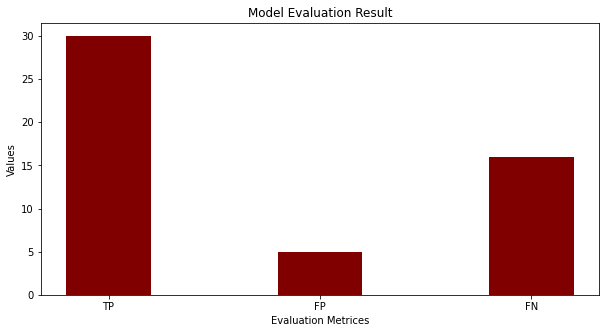

In [12]:

import matplotlib.pyplot as plt
# set width of bar
plotData = {'TP' : 30, 'FP':5, 'FN':16}
#make list for x and y axis
evalMetrices = list(plotData.keys())
evalValues = list(plotData.values())
 
fig = plt.figure(figsize = (10, 5))

plt.bar(evalMetrices, evalValues, color ='maroon',
        width = 0.4)

plt.xlabel("Evaluation Metrices")
plt.ylabel("Values")
plt.title("Model Evaluation Result")
plt.show()
 
# plt.legend()
plt.show()


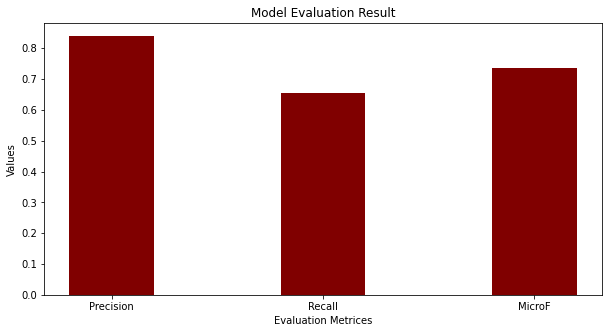

In [13]:
# set width of bar
plotData = {'Precision': 0.839779005524862, 'Recall':0.6551724137931034, 'MicroF': 0.7360774818401937}
 
#make list for x and y axis
evalMetrices = list(plotData.keys())
evalValues = list(plotData.values())
 
fig = plt.figure(figsize = (10, 5))

plt.bar(evalMetrices, evalValues, color ='maroon',
        width = 0.4)

plt.xlabel("Evaluation Metrices")
plt.ylabel("Values")
plt.title("Model Evaluation Result")
plt.show()
 
# plt.legend()
plt.show()

## Restore Test Data to Training Set and Train Model on Full Training Set

In [ ]:
#Upon attempting training, there was not enough RAM/it was too slow to process all texts in their entirities.
#As such, following script is used to compress the training data.  It breaks the publications up into sentences.  It then picks,
# from each publication, one sentence that contains the data set name inside it, and one sentence that does not.

#set our custom entity label to be trained on later
LABEL = 'data'

TRAIN_DATA = []

#loop through tuples in original data
#hit_count and miss_count serve as counters for how many sentences we have already extracted from this particular paper
for paper in DATA:
  hit_count = 0
  miss_count = 0

  #determine if the paper we are looking at contains any entities
  entities = paper[1]['entities']
  if len(entities) > 0:
    #store the dataset name for this publication
    dataset = paper[0][entities[0][0]:entities[0][1]-1]

  #split data into sentences, approximately (based on the '.' puncutation mark)
  sentences = paper[0].split('.')

  #loop through sentences
  for sentence in sentences:
    this_ent_dict = {"entities": []}
    if dataset in sentence:
      hit_count +=1

      #find all occurences of explicit mentions of the dataset in this sentence
      for m in re.finditer(dataset,sentence):
        this_ent_dict['entities'].append((m.start(), m.end()+1, LABEL))
      #compressed data: append a tuple of just the sentence (as opposed to the entire paper) containing the dataset entity
      TRAIN_DATA.append((sentence, this_ent_dict))
    
    #after find one sentence containing a dataset, append two that do not contain it
    elif hit_count > 0 and miss_count <= hit_count:
      miss_count += 1
      TRAIN_DATA.append((sentence, this_ent_dict))

    #when have two sentences from this paper (one containing dataset and one without), move on to next paper
    if hit_count >= 1 and miss_count >= 2:
      break

In [ ]:
#number of entries ((sentence, entity-locations) tuples) in the compressed dataset
print("number of (sentence, datset_location) tuples in the compressed data: ", len(TRAIN_DATA))

In [ ]:
#find and remove all sentences containing no chars (ex: "", " ", "      ") as these cause an error in the SpaCy training algorithm

count = 0
sen = 0
while sen < len(TRAIN_DATA):
  #if the sentence contains some chars, move on to the next sentence
  if TRAIN_DATA[sen][0].strip():
      sen += 1
  
  #if it is a blank sentence, delete it
  else:
      # print(TRAIN_DATA[sen])
      del TRAIN_DATA[sen]
      count+=1


print("Number of blank sentences we removed: ", count)

In [ ]:
#script derived from https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718

#create empty model
nlp = sp.blank('en')
print("created blank english model")

#add ner (entity recognizer) to the pipeline
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
else:
    ner = nlp.get_pipe('ner')

#add our custom entity label to the entity recognizer
ner.add_label(LABEL)
optimizer = nlp.begin_training()

#set number of epochs we want our model to perform
n_iter = 10

#make sure we only train our ner pipe to speed up processing
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    for itn in range(n_iter):
        print(itn)
        random.shuffle(TRAIN_DATA)
        losses = {}
        #split data into batches of 500 sentences
        batches = minibatch(TRAIN_DATA, size=500)
        for batch in batches:
            print('batch size', len(batch))
            #extract the sentence and the entities it contains for each sentence
            texts, annotations = zip(*batch)
            #update the weights
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35,
                        losses=losses)
        #loss after this epoch
        print('Losses', losses)


# Save model 
output_dir = Path('./models/spacy_full')
if not output_dir.exists():
    output_dir.mkdir()
nlp.meta['name'] = 'SpaCy_Full'  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

## Make Predictions on Kaggle Test Data

In [14]:
#load text publications
import os

directory = './data/test/'

#this list used to store test data text and id numbers
SPACY_TEST = []

#loop through publications in directory housing test data
for file in os.listdir(directory):
    this_pub = ""
    #path to file
    this_pub_id = os.path.join(directory, file)
    #load json file
    this_pub_json = json.load(open(this_pub_id))
    #append all text from the publication in to one (super-long!) string
    for section in this_pub_json:
        this_pub += section['text']
    #get the text id
    id = file.split('.')[0]
    print(id)
    #append a tuple of the text and its id
    SPACY_TEST.append((this_pub,id))
    

2100032a-7c33-4bff-97ef-690822c43466
2f392438-e215-4169-bebf-21ac4ff253e1
3f316b38-1a24-45a9-8d8c-4e05a42257c6
8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60


In [15]:
#Load SpaCy ner model trained on full training data

output_dir = Path('./models/spacy_full')
print("Loading from", output_dir)
nlp3 = sp.load(output_dir)

Loading from models/spacy_full


In [17]:
#function provided on Kaggle competition to clean dataset label for submission
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

#store predictions in a list
predictions = []
#loop through test set publications
for pub in SPACY_TEST:
    this_pred = []
    #break up test set into sentences
    sentences = pub[0].split('.')
    #make predicitons on each sentence
    for sentence in sentences:
        doc = nlp3(sentence)
        #loop through entities found in this sentence, if they contain chars store them, make sure to only store once
        for ent in doc.ents:
            if len(ent.text) > 0:
                this_ent = clean_text(ent.text)
                #remove any trailing or leading white spaces
                this_ent = this_ent.strip()
                if this_ent not in this_pred:
                    this_pred.append(this_ent)
    #clean for Kaggle submission, concatenates multiple predictions into one string separated by a pipe ('|') deliminator
    for pred in range(1, len(this_pred)):
        this_pred[0] += '|' + this_pred[pred]
    #if no entities predicted, add empty string so length still matches up with number of publications
    if len(this_pred) == 0:
        this_pred.append("")
    predictions.append([this_pred[0]])

predictions

[['adni'],
 ['trends in international mathematics and science study'],
 ['management|slosh'],
 ['rural urban continuum codes']]

In [ ]:
#write predictions in appropriate submission format to a .csv file
#source: https://realpython.com/python-csv/
import csv
with open('submission.csv', mode='w') as sub:
    sub = csv.writer(sub, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    #header row
    sub.writerow(['Id','PredictionString'])
    
    #for each prediction, format it to the two-column format required for Kaggle submission
    for p in range(0, len(predictions)):
        sub.writerow([SPACY_TEST[p][1],predictions[p][0]])